In [ ]:
!conda install -c anaconda mingw
!conda install -c conda-forge fluidsynth

# IMPORTS

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()

# DATA LOADING

In [ ]:
midi_folder = 'C:\\Users\\Ali--\\Documents\\midi_100'

dataset_files = []
i = 0
for f in os.listdir(midi_folder):
  if i <= 100:
    if f !=".ipynb_checkpoints":
      dataset_files.append(os.path.join(midi_folder, f))
  else:
    break
  i += 1

In [ ]:
from midi2audio import FluidSynth
from IPython.display import Audio

def play_midi(midi_filename):
    """Call `play_midi` with a path to a midi file will show a midi player on Google Colab."""
    FluidSynth("font.sf2").midi_to_audio(midi_filename, 'test.wav')
    return Audio("test.wav")

In [ ]:
from mido import MidiFile, MidiTrack

def get_midi_file_notes(filename):
    """Returns the sequence of notes played in the midi file
    There are 128 possible notes on a MIDI device, and they are numbered 0 to 127.
    The middle C is note number 60. Larger numbers indiciate higher pitch notes,
    and lower numbers indicate lower pitch notes.

    You can read more about the midi representation below, but it is not
    necessary for this assignment.
    http://midi.teragonaudio.com/tech/midispec/noteon.htm
    """
    notes = []
    for msg in  MidiFile(filename):
        if msg.type == 'note_on':
            notes.append(msg.note)
    return notes

# DATA TRANSFORMATION

In [ ]:
CONTEXT_LENGTH = 250
def gen_input_output(notes, context_length=CONTEXT_LENGTH):
    """
    Generate a list of training data points, each of the form (x, t),
    where "x" is a list of length `context_length` consisting of the
    previous notes, and "t" is the corresponding next note.

    Parameters:
        `notes` - a sequence of notes in a piece, generated
                  from calling `get_midi_file_notes`
        `context_length` - length of each context

    Returns: a list of training pairs (x, t), with len(x) == context_length
    """
    D = []
    for i in range(len(notes) - context_length):
        seq = notes[i:i+context_length]
        next_note = notes[i+context_length]
        D.append((seq, next_note),)
    
    D.append((notes[-context_length:], 0),)
    # Since the note 0 never appears in any of our pieces,
    # we use note 0 to denote END OF SONG. In general, we choose
    # a special value to denote the END OF SONG (usually a new
    # category that doesn't match an actual note), so that our
    # model might learn to end a song.
    return D

In [ ]:
def get_X_t_new(D):
    """
    Generate the data matrix "X" and target vector "t" from a data set "D",

    Parameters:
        `D` - a list of pairs of the form (x, t), returned from
              the function `gen_input_output`

    Returns: a tuple (X, t) where
        `X` - a numpy array of shape (N, D), the data matrix
        `t` - a numpy array of shape (N,),
              with each value representing the index of the target note
    """
    t = np.array([next_note for seq, next_note in D])
    X = np.array([seq for seq, next_note in D])
    return X, t

In [ ]:
def generate_data_for_files(files):
    Xs, ts = [], []
    for file in files:
        try:
          notes = get_midi_file_notes(file)
          if (len(notes) > 250) and (len(notes) < 20000):
            D = gen_input_output(notes)
            X, t = get_X_t_new(D)
            Xs.append(X)
            ts.append(t)
        except Exception as e:
          print(f"song:{file}   error:{e}")
    X = np.concatenate(Xs, axis=0)
    t = np.concatenate(ts, axis=0)
    return X, t

### Data

In [ ]:
X2, t2 = generate_data_for_files(dataset_files[:])

In [ ]:
X2_train, X2_test, t2_train, t2_test = train_test_split(X2, t2, test_size=0.2, random_state=42)
X2_train, X2_val, t2_train, t2_val = train_test_split(X2_train, t2_train, test_size=0.25, random_state=42)

# MODEL

In [ ]:
class PositionalEncoding(layers.Layer):
    def __init__(self, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.d_model = d_model

    def get_angles(self, positions, i, d_model):
        angles = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return positions * angles

    def call(self, inputs):
        seq_length = inputs.shape.as_list()[1]
        positions = np.arange(seq_length)[:, np.newaxis]
        i = np.arange(self.d_model)[np.newaxis, :]
        angle_rads = self.get_angles(positions, i, self.d_model)

        # Apply sine to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # Apply cosine to odd indices in the array; 2i + 1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return inputs + tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def build_transformer(num_notes, context_len, d_model, num_heads,
                      num_layers, dropout_rate):
    # input layers initialization
    inputs = layers.Input(shape=(context_len,))
    
    # embedding layer
    x = layers.Embedding(num_notes, d_model)(inputs)

    # normalize
    x = layers.LayerNormalization(epsilon=0.000001)(x)
    
    # positional encoding
    x = PositionalEncoding(d_model)(x)

    # 2 layer blocks to start
    for i in range(num_layers):
        # attention layer
        attention = layers.MultiHeadAttention(num_heads, d_model // num_heads,
                                              dropout=dropout_rate)(x, x)  
        # add & normalize
        x = layers.Add()([x, attention])
        x = layers.LayerNormalization()(x)

        # Feed Forward layer
        feed_forward = layers.Dense(d_model, activation='relu')(x)
        x = layers.Add()([x, feed_forward])
        x = layers.LayerNormalization()(x)
    
    # Final Pooling, dropout and softmax
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(num_notes, activation='softmax')(x)

    return Model(inputs, x)


# HYPERPARAMETER TUNING

In [ ]:
from keras_tuner import HyperModel
from keras_tuner.tuners import BayesianOptimization

def build_transformer_tuning(hp):
    context_len = 250
    num_notes = 128

    d_model = hp.Int('d_model', min_value=128, max_value=512, step=128)
    num_heads = hp.Int('num_heads', min_value=4, max_value=8, step=2)
    num_layers = hp.Int('num_layers', min_value=3, max_value=5, step=1)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.3, step=0.1)

    model = build_transformer(num_notes, context_len, d_model, num_heads, num_layers, dropout_rate)

    learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-4, sampling='LOG')
    decay_steps = hp.Int('decay_steps', min_value=1000, max_value=10000, step=1000)
    decay_rate = hp.Float('decay_rate', min_value=0.9, max_value=0.99, step=0.01)

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
tuner = BayesianOptimization(
    build_transformer_tuning,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

In [ ]:
tuner.search(X2_train, t2_train, epochs=10, validation_data=(X_val, t_val), callbacks=[early_stopping])

# Training

In [ ]:
# Set Parameters
num_notes = 128
context_len = 250

# Best HyperParameters:
d_model = 512
num_heads = 6
num_layers = 5
dropout_rate = 0.1

learning_rate = 5.6189e-05
decay_steps = 8000
decay_rate = 0.9

In [ ]:
model3 = build_transformer(num_notes, context_len, d_model, num_heads, num_layers, dropout_rate)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
model3.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

In [ ]:
history = model3.fit(X2_train, t2_train, epochs=12, validation_data=(X2_val, t2_val), callbacks=[early_stopping])

Epoch 1/12
11722/11722 [==============================] - 768s 65ms/step - loss: 2.7915 - accuracy: 0.2281 - val_loss: 2.5242 - val_accuracy: 0.2912
Epoch 2/12
11722/11722 [==============================] - 968s 83ms/step - loss: 2.3972 - accuracy: 0.3276 - val_loss: 2.2921 - val_accuracy: 0.3594
Epoch 3/12
11722/11722 [==============================] - 1342s 115ms/step - loss: 2.1693 - accuracy: 0.3902 - val_loss: 2.1347 - val_accuracy: 0.4021
Epoch 4/12
11722/11722 [==============================] - 1461s 125ms/step - loss: 1.9901 - accuracy: 0.4379 - val_loss: 2.0223 - val_accuracy: 0.4340
Epoch 5/12
11722/11722 [==============================] - 1232s 105ms/step - loss: 1.8380 - accuracy: 0.4788 - val_loss: 1.9311 - val_accuracy: 0.4618
Epoch 6/12
11722/11722 [==============================] - 785s 67ms/step - loss: 1.7075 - accuracy: 0.5137 - val_loss: 1.8747 - val_accuracy: 0.4800
Epoch 7/12
11722/11722 [==============================] - 715s 61ms/step - loss: 1.5929 - accuracy: 

# Test Set

In [ ]:
np.count_nonzero(t_test == 42) / len(t_test)

In [ ]:
loss, accuracy = model.evaluate(X2_test, t2_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

3908/3908 [==============================] - 85s 22ms/step - loss: 1.5117 - accuracy: 0.5869
Test Loss: 1.5116686820983887
Test Accuracy: 0.5869391560554504


# GRAPH

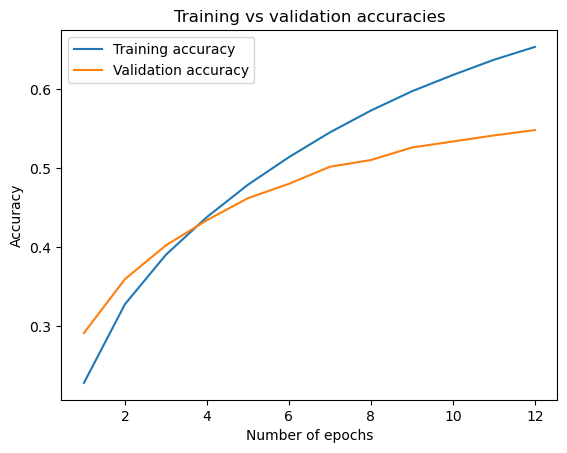

In [ ]:
train_accs = history.history['accuracy']
val_accs = history.history['val_accuracy']

x = list(range(1, len(train_accs)+1))
plt.title("Training vs validation accuracies")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")

plt.plot(x, train_accs, label='Training accuracy')
plt.plot(x, val_accs, label='Validation accuracy')
plt.legend()

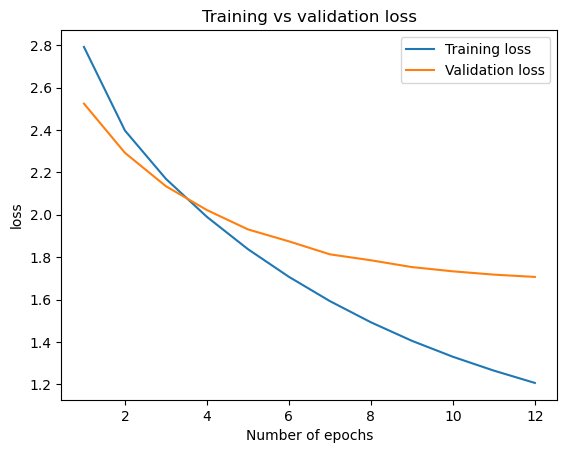

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

x = list(range(1, len(train_loss)+1))
plt.title("Training vs validation loss")
plt.xlabel("Number of epochs")
plt.ylabel("loss")

plt.plot(x, train_loss, label='Training loss')
plt.plot(x, val_loss, label='Validation loss')
plt.legend()

# Generation

In [ ]:
def generate_midi(notes, outfile):
    from mido import MidiFile, MidiTrack, Message

    new_mid = MidiFile()
    new_track = MidiTrack()
    new_mid.tracks.append(new_track)

    for note in notes:
        new_track.append(Message('note_on', note=note, velocity=64, time=128))
    new_mid.save(outfile)

In [ ]:
def generate_piece(model, seed, max_len=500):
    """
    Generate a piece of music given the model and an initial
    "seed" sequence of notes at the beginning of the piece.

    The piece is generated one note at a time by using, as input
    to the model, the previous 20 notes. The model outputs a 
    probability distribution over the next possible note, and we
    will take the most probable note as the next note in our piece.

    Parameters:
        `model` - an instance of MLPModel
        `seed` - a sequence of notes at the beginning of a piece,
                 e.g. generated from calling `get_midi_file_notes`
                 must be at least as long as context_len
        `max_len` - maximum number of total notes in the piece.

    Returns: a list of sequence of notes with length at most `max_len`
    """

    generated = seed
    while len(generated) < max_len:
        # Use the model to predict the next note
        seq = generated[-context_len:]

        # X = np.reshape(make_onehot(np.array(seq)), (1, context_len, num_notes))
        X = np.reshape(seq, (1, context_len))
        # print(X.shape)

        pred = model.predict(X)
        next_note = np.argmax(pred)
        print(next_note)

        generated = np.append(generated, next_note)
    return generated

In [ ]:
seed = X_val[500] # Can change to anything else (at least context_len away to hear something brand new)
# print(seed)

notes_randnet = generate_piece(model2, seed)

In [ ]:
generate_midi(notes_randnet, 'testing.mid')
play_midi('CSC413/testing.mid')

In [ ]:
model3.Summary()

In [ ]:
for i in range(len(X_test)):
    t = t_train[i]
    x = np.reshape(X_train[i], (1 ,context_len))
    pred = np.argmax(model3.predict(x))
    print("prediction vs output:", pred, t)
    if (pred == t) and (pred != 42):
        print("Model prediction:", pred)
        print("Choose-42-model prediction:", 42)
        print("Actual note:", t)
        break

prediction vs output: 42 42
prediction vs output: 54 54
Model prediction: 54
Choose-42-model prediction: 42
Actual note: 54


In [ ]:
model3.save('CSC413')

In [ ]:
model5 = tf.keras.models.load_model('CSC413')

In [ ]:
loss, accuracy = model5.evaluate(X2_test, t2_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

3908/3908 [==============================] - 187s 48ms/step - loss: 1.7135 - accuracy: 0.5496
Test Loss: 1.7134736776351929
Test Accuracy: 0.5495641231536865
